# Plot Cityscapes inter-class : intra-class distance ratio histogram

In [1]:
import os
import pathlib
import tqdm
import numpy as np
import pickle
from scipy.ndimage.filters import uniform_filter
from matplotlib import pyplot as plt


Change `OUT_PATH` to a directory in which you want to save the plots.

In [2]:
IN_PATH = pathlib.Path(r'./results/distances')
# OUT_PATH = pathlib.Path(r'....')
OUT_PATH = None

We originally ran the `intra_inter_class_patch_dist.py` program on a cluster, using `--batch_size=10`, with the job number determining the batch `--batch=${JOB_INDEX}`. Please pardon our use of the term batch here. In this case we are dividing the 1000 patches (the default, set using `--n_patches`) into batches of 10, therefore dividing the work between 100 processes that can be processed in parallel.

The code below loads all the output generated and joins it together.

In [31]:
def dict_concat(x, y):
    j = dict()
    j.update(x)
    for k in y.keys():
        if k in j:
            if isinstance(y[k], list):
                j[k] = j[k] + y[k]
            elif isinstance(y[k], np.ndarray):
                j[k] = np.append(j[k], y[k], axis=0)
            else:
                pass
        else:
            j[k] = y[k]
    return j

def join(data):
    data_out = {}
    for k, v in data.items():
        if v[0].ndim > 0:
            lengths = np.array([len(x) for x in v])
            max_len = lengths.max()
            if (lengths != max_len).any():
                max_val = np.array([x.max() for x in v]).max()
                v = [np.pad(x, [[0, max_len-len(x)]] + [[0,0]] * (x.ndim-1), mode='constant',
                            constant_values=max_val) for x in v]
        data_out[k] = np.array(v)
    return data_out

data = {}
for i in range(1, 101):
    path = IN_PATH / 'intra_inter_class_distances_{}.pkl'.format(i)
    with path.open('rb') as f_in:
        batch = pickle.load(f_in)
        data = dict_concat(data, batch)
        
data = join(data)

for k in data.keys():
    print('{}: {}'.format(k, data[k].shape))

same_image_intra_class_dists: (1000, 1000)
same_image_intra_class_coords: (1000, 1000, 3)
same_image_inter_class_dists: (1000, 1000)
same_image_inter_class_coords: (1000, 1000, 3)
other_image_intra_class_dists: (1000, 1000)
other_image_intra_class_coords: (1000, 1000, 3)
other_image_inter_class_dists: (1000, 1000)
other_image_inter_class_coords: (1000, 1000, 3)
anchor_negative_img_dir_y_x_cls: (1000, 5)
boundary_dists: (1000,)


In [32]:
anchor_negative_img_dir_y_x_cls = data['anchor_negative_img_dir_y_x_cls']
same_image_intra_class_dists = data['same_image_intra_class_dists']
same_image_intra_class_coords = data['same_image_intra_class_coords']
same_image_inter_class_dists = data['same_image_inter_class_dists']
same_image_inter_class_coords = data['same_image_inter_class_coords']
other_image_intra_class_dists = data['other_image_intra_class_dists']
other_image_intra_class_coords = data['other_image_intra_class_coords']
other_image_inter_class_dists = data['other_image_inter_class_dists']
other_image_inter_class_coords = data['other_image_inter_class_coords']
boundary_dists = data['boundary_dists']


In [34]:
((anchor_negative_img_dir_y_x_cls[:, None, :] == anchor_negative_img_dir_y_x_cls[None, :, :]).all(axis=2) == np.eye(1000)).all()

True

We want to look at the input data distribution, considering inter-class and intra-class variation.
Although we use inter-class and intra-class distances here.

We randomly chose 1,000 anchor patches from the Cityscapes dataset that are centred on pixels that are adjacent to a class boundary.

For the inter-class distances, we compute the $L^2$ distance between the anchor patch $A_i$ and a negative patch $N_i$ where the central pixels of $N_i$ is chosen such that the central pixels of $A_i$ and $N_i$ are immediate neighbours that lie either side of a class boundary.

For the intra-class distance, we consider the distance over which the model must generalise within the same class. For a given anchor patch $A_i$ we search for a positive patch $P_i$ from the set of patches $S_i$, where $S_i$ is:

- all patches that can be extracted from the entire dataset in a sliding window fashion
- where the patches in $S_i$ do not come from the same image as $A_i$
- where the central pixel of the patches in $S_i$ has the same class as that of $A_i$

We choose the patch $P_i$ from $S_i$ such that has the smallest $L^2$ distance to $A_i$. Thus thus distance represents the best case distance over which the model must generalise within a class.


#### The figures
Below, we plot two figures.

First we plot a histogram of the distances $|N_i - A_i|$ and $|P_i - A_i|$.

Secondly we plot  histogram of the ratio $\frac{|N_i - A_i|}{|P_i - A_i|}$.

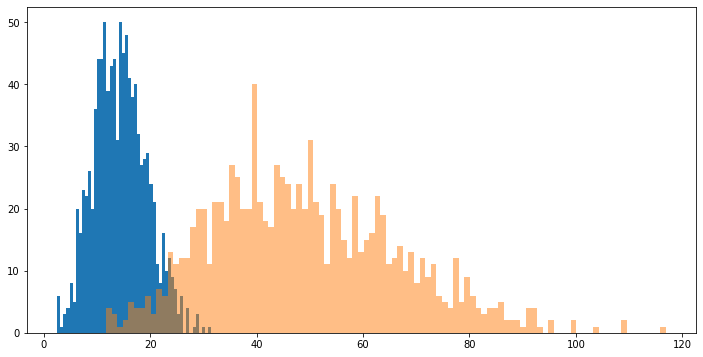

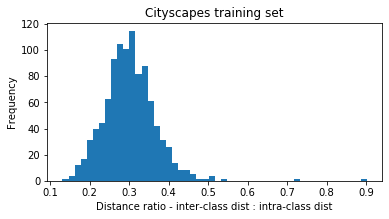

In [46]:
plt.figure(figsize=(12,6))
plt.hist(boundary_dists, bins=50)
plt.hist(other_image_intra_class_dists[:, 0], bins=100, alpha=0.5)
plt.show()

plt.figure(figsize=(6,3))
# plt.hist(other_image_intra_class_dists[:, 0] / boundary_dists, bins=50)
plt.hist(boundary_dists / other_image_intra_class_dists[:, 0], bins=50)
plt.gcf().subplots_adjust(bottom=0.15)
plt.title('Cityscapes training set')
plt.ylabel('Frequency')
plt.xlabel('Distance ratio - inter-class dist : intra-class dist')
if OUT_PATH is not None:
    plt.savefig(str(OUT_PATH / 'cityscapes_dist_ratio_hist.pdf'))
    plt.savefig(str(OUT_PATH / 'cityscapes_dist_ratio_hist_png.png'))

plt.show()



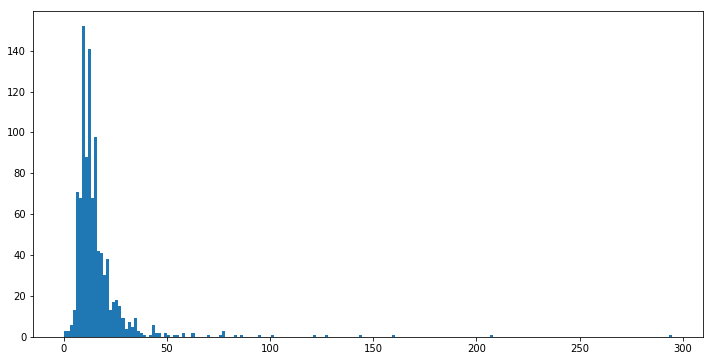

In [41]:
closer = (same_image_dists <= other_image_dists[:, 0:1])
offset_dists = np.sqrt(((same_image_coords[:, :, 1:3] - img_dir_ij[:, None, 2:4])**2).sum(axis=2))
f = (closer * offset_dists).max(axis=1)
plt.figure(figsize=(12,6))
plt.hist(f, bins=200)
plt.show()

